# Day-to-day evolution of supply and demand
Module for simulating ridesourcing evolution

Contribution by Arjan de Ruijter - a.j.f.deruijter@tudelft.nl

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim and MaaSSim/MaaSSim to path (not needed if already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from MaaSSim.utils import save_config, get_config, load_G, generate_demand, initialize_df, empty_series, \
    slice_space, test_space
from MaaSSim.maassim import Simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.d2d import *
from MaaSSim.shared import prep_shared_rides

In [4]:
import pandas as pd
import logging
import matplotlib.pyplot as plt

In [5]:
# Load config
params = get_config('../../data/config/delft.json')  # load configuration

In [6]:
# Experiment replications and number of threads to be used
params.parallel.nReplications = 1
params.parallel.nThread = 3

# Main experimental settings
params.nP = 1000 # travellers
params.nV = 20 # drivers
params.nD = 10 # days
params.simTime = 8 # hours

In [7]:
# Other day-to-day settings
params.evol.drivers.omega = 5 # recency: until this day perfect memory, afterwards weight 1/recency for last experience
params.evol.drivers.res_wage.mean = 80 #euros
params.evol.drivers.res_wage.std = 20 #euros
params.evol.drivers.init_inc_ratio = 1 #expected income of informed drivers at start of sim as ratio of res wage

params.evol.drivers.inform.prob_start = 1 # probability of being informed at start of sim
params.evol.drivers.inform.beta = 0.2 # information transmission rate

params.evol.drivers.regist.prob_start = 1 # probability of being registered if informed at start of sim
params.evol.drivers.regist.beta = 0.2 # registration choice model parameter
params.evol.drivers.regist.cost_comp = 20 # daily share of registration costs (euros)
params.evol.drivers.regist.samp = 0.2 # probability of making regist decision when informed (and unregistered)

params.evol.drivers.particip.beta = 0.1 # participation choice model parameter
params.evol.drivers.particip.probabilistic = True # stochasticity in participation choice

# params.evol.min_it = 10 # minimum number of days in simulation
# params.evol.conv = 0.005 # convergence criterion, currently not in use

# Financial settings
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = 1.21 #euro/km
params.platforms.min_fare = 0 # euro
params.platforms.comm_rate = 0.25 #rate
params.drivers.fuel_costs = 0.25 #euro/km

# Demand settings
# params.min_dist = 2 # minimum OD distance when creating requests
# params.max_dist = 30 # maximum OD distance

# Start time
params.t0 = pd.Timestamp.now()

In [8]:
inData = load_G(inData, params, stats=True)  # download graph for the 'params.city' and calc the skim matrices
inData = generate_demand(inData, params, avg_speed = False)
fixed_supply = generate_vehicles_d2d(inData, params)
inData.vehicles = fixed_supply.copy()
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = pd.concat([inData.platforms,pd.DataFrame(columns=['base_fare','comm_rate','min_fare'])])
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[params.platforms.fare,'Uber',30,params.platforms.base_fare,params.platforms.comm_rate,params.platforms.min_fare,]

inData = prep_shared_rides(inData, params.shareability)  # prepare schedules

In [9]:
d2d = dict()
sim = Simulator(inData, params=params,
                    kpi_veh = D2D_veh_exp,
                    f_driver_out = D2D_driver_out,
                    logger_level=logging.WARNING)  # initialize

for day in range(params.get('nD', 1)):  # run iterations
    sim.make_and_run(run_id=day)  # prepare and SIM
    sim.output()  # calc results

    d2d[day] = update_d2d_exp(sim=sim,params=params)
    res_inf = word_of_mouth(inData, params = params)
    inData.vehicles.informed = res_inf
    res_regist = platform_regist(inData, d2d[day], params = params)
    inData.vehicles.registered = res_regist.registered
    inData.vehicles.expected_income = res_regist.expected_income
    inData.vehicles.pos = fixed_supply.pos

evol_micro, evol_stats = D2D_summary(d2d) # multi-day stats

11-12-20 10:26:00-WARNING-Setting up 8h simulation at 2020-12-11 06:26:09 for 20 vehicles and 1000 passengers in Delft, Netherlands
11-12-20 10:26:30-WARNING-day 0: simulation time 28.3 s
11-12-20 10:26:31-WARNING-assertion tests for simulation results - passed
11-12-20 10:27:08-WARNING-day 1: simulation time 35.4 s
11-12-20 10:27:09-WARNING-assertion tests for simulation results - passed
11-12-20 10:27:42-WARNING-day 2: simulation time 31.9 s
11-12-20 10:27:44-WARNING-assertion tests for simulation results - passed
11-12-20 10:28:19-WARNING-day 3: simulation time 34.0 s
11-12-20 10:28:21-WARNING-assertion tests for simulation results - passed
11-12-20 10:28:52-WARNING-day 4: simulation time 30.3 s
11-12-20 10:28:54-WARNING-assertion tests for simulation results - passed
11-12-20 10:29:26-WARNING-day 5: simulation time 31.2 s
11-12-20 10:29:28-WARNING-assertion tests for simulation results - passed
11-12-20 10:30:03-WARNING-day 6: simulation time 33.6 s
11-12-20 10:30:04-WARNING-assert

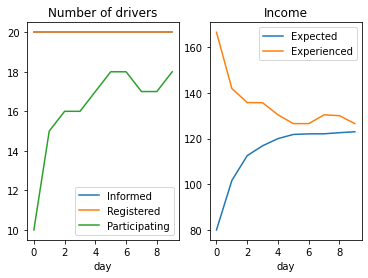

In [10]:
# Plot number of drivers and income
fig, axes = plt.subplots(nrows=1, ncols=2)
evol_stats[['regist','inform','particip']].plot(ax = axes[0])
axes[0].set_title('Number of drivers')
axes[0].legend(['Informed','Registered','Participating'])
evol_stats[['mean_perc_inc','mean_exp_inc']].plot(ax = axes[1])
axes[1].set_title('Income')
axes[1].legend(['Expected','Experienced'])